In [7]:
# import dgl # huggingface 같은 라이브러리
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from lib import Trainer, RNNTrainer
from lib import save_figure_predict
from lib import matplotlib_plot_font
# from models import LSTM
from lib import compute_metrics
from model_select import model_selection

import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from math import ceil
import warnings
warnings.filterwarnings('ignore')

matplotlib_plot_font()
device = torch.device("cpu")

In [8]:
def seq_data(data,sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(data) - sequence_length):
        x_seq.append(data[i:i+sequence_length])
        y_seq.append(data[i+sequence_length])
        # print(y_seq)
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)
    
def seed_everything(seed = 42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'Seed set = {seed}')
    
seed_everything()

Seed set = 42


In [19]:
##################
## Load Dataset ##
##################

region_type = 'city'
df2 = pd.read_csv(f'/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/KCDC_data/Processing_Results/smoothing_1_{region_type}_mean.csv', index_col=0, encoding='cp949')

# df = df2.iloc[100:533] # 델타 : 554, 540, 533 오미크론 : 707, 693, 686 
df2 = df2.iloc[:850] #340 326 319
df = df2.diff()
df = df.dropna()

############################################
## train, test, validation length setting ##
############################################

# split_date = '2021-11-25'
split_date = '2020-11-23' #'2021-06-25' #2020-11-23
val_ratio = 0.2

train_df = df[df.index < split_date]
test = df.iloc[len(train_df):, :]

len_val = int(train_df.shape[0] * val_ratio)
len_train = train_df.shape[0] - len_val
train = train_df.iloc[:len_train,:]
val = train_df.iloc[len_train :, :]


### 컬럼을 숫자로 바꿔줌 ###
region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region
# df.columns = list(region_dict.keys())

y_pred = pd.DataFrame({})
fig = plt.figure(figsize=(25,15), facecolor='white')
true_df2 = []
pred_list = []

############################
## Hyperparameter Setting ##
############################

diff_ = "1st"
suptitle_1 = 'Standard Scaler, LSTM'
epochs = 50
batch_size = 16
# num_layers = 1
# hidden_size = 16
# output_size = 16
TIME_STEPS = 5
learning_rate = 1e-2
criterion = nn.MSELoss()

import shutil
MODEL_NAME = 'RNN'
tmp = ""
dataset_name = "Baseline_340"
horizon = len(test)-TIME_STEPS

result_dir = ('%s'+tmp) % (MODEL_NAME)
model_dir = ('%s'+tmp) % (MODEL_NAME)
Figure_path = os.path.join('Result', dataset_name, 'Figure', str(horizon), result_dir)
Diameter_path = os.path.join('Result', dataset_name, 'Diameter', str(horizon), result_dir)
Pred_path = os.path.join('Result', dataset_name, 'Pred', str(horizon), result_dir)
model_path = os.path.join('Save_model', dataset_name, str(horizon), model_dir)


if os.path.exists(Figure_path):
    shutil.rmtree(Figure_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(Diameter_path):
    shutil.rmtree(Diameter_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(Pred_path):
    shutil.rmtree(Pred_path) # 해당 경로 데이터 모두 삭제
if os.path.exists(model_path):
    shutil.rmtree(model_path) # 해당 경로 데이터 모두 삭제
    
os.makedirs(Figure_path) # 새로 폴더 생성
os.makedirs(Diameter_path) # 새로 폴더 생성
os.makedirs(Pred_path) # 새로 폴더 생성
os.makedirs(model_path) # 새로 폴더 생성


MAE_LSTM_list, RMSE_LSTM_list = [], []
# date_split = f"{df.index[0]} ~ {df.index[len_train]} ~ {df.index[len_train + len_val]} ~ {df.index[-1]}"
# print(date_split)
# for i in [0]:
for i, region in enumerate(df.columns):
# for i, region in enumerate(['인천 동구', '경기 시흥시']):
    
    #######################
    ## Define DataLoader ##
    #######################
    
    train = df[[region]][:len_train]
    val = df[[region]][ len_train: len_train + len_val]
    test = df[[region]][ len_train + len_val:]
    
    scaler = StandardScaler()

    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    test = scaler.transform(test)

    x_train_seq, y_train_seq = seq_data(train, TIME_STEPS)
    x_val_seq, y_val_seq = seq_data(val, TIME_STEPS)
    x_test_seq, y_test_seq = seq_data(test, TIME_STEPS)
    # print(x_train_seq.shape, x_val_seq.shape, x_test_seq.shape)
    
    date_split = f"{df.index[0]} ~ {df.index[len(x_train_seq)-1]} ~ {df.index[len(x_train_seq)+TIME_STEPS + len(x_val_seq)+TIME_STEPS*2-1]} ~ {df.index[-1]}"
    print(date_split)
    
    # input(" stop ")
    # horizon = len(y_test_seq)
    train_torch = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
    val_torch = torch.utils.data.TensorDataset(x_val_seq, y_val_seq)
    test_torch = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
    
    train_loader = torch.utils.data.DataLoader(dataset=train_torch, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset=val_torch, batch_size=batch_size, shuffle=False)
    # test_loader = torch.utils.data.DataLoader(dataset=test_torch, batch_size=batch_size, shuffle=False)

    # save_path = f"save_model/lstm_smooth_3_{suptitle_2}_{i}.pt"
    
    ############################
    ## Define Model and Train ##
    ############################
    
    model = model_selection(MODEL_NAME='LSTM', TIME_STEPS=TIME_STEPS, device=device, save_path=model_path)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    trainer = RNNTrainer(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        test_loader=torch.tensor(x_test_seq, dtype=torch.float32),
                        loss=criterion,
                        optimizer=optimizer,
                        scaler=scaler,
                        device=device,
                        save_path=model_path,
                        res_df = df)

    
    trainer.train(epochs)
    val_loss, epoch = trainer.train(epochs)
    pred = trainer.predict(diff_, horizon)
    pred_5, gt = trainer.multi_step_ahead_predict(split_date = split_date,
                                                  TIME_STEPS = TIME_STEPS,
                                                  horizon = 5,
                                                  y_test = torch.tensor(y_test_seq, dtype=torch.float32))

    #######################
    ## Calculate Metrics ##
    #######################
    
    ground_truth = df2.diff().loc[df[df.index >= split_date].index[TIME_STEPS:TIME_STEPS+horizon]]
    
    # true_df2 += df2.iloc[-horizon:,i].tolist()
    true_df2 += ground_truth.iloc[:,i].tolist()
    pred_list += list(pred)
    
    # Metric of each region 
    RMSE_LSTM, _ = compute_metrics(ground_truth.iloc[:,i], pred, metric='rmse')
    MAE_LSTM, _ = compute_metrics(ground_truth.iloc[:,i], pred, metric='mae')
    y_pred[region] = pred
    
    MAE_LSTM_list.append(MAE_LSTM.item())
    RMSE_LSTM_list.append(RMSE_LSTM.item())
    
    
true_df2 = np.array(true_df2).reshape(-1,)
pred_list = np.array(pred_list).reshape(-1,)

# Total Metric
_, RMSE_total = compute_metrics(true_df2, pred_list, metric='rmse')
_, MAE_total = compute_metrics(true_df2, pred_list, metric='mae')

#####################
## Save Prediction ##
#####################

# Save for Total Metric of Each Metric
pd.DataFrame({
              'MAE_LSTM' : MAE_LSTM_list,
              'RMSE_LSTM' : MAE_LSTM_list
              }, index=df.columns).to_csv(f'{Pred_path}/RNN_region_metric.csv', encoding='cp949')

pd.DataFrame({'MAE_total' : MAE_total,
              'RMSE_total' : RMSE_total,
              }, index=['LSTM']).to_csv(f'{Pred_path}/RNN_total_metric.csv', encoding='cp949')

y_pred['신고일'] = df2.index[-horizon:]
y_pred.set_index('신고일', inplace=True)
y_pred.to_csv(f'{Pred_path}/pred_LSTM_{region_type}.csv', encoding='cp949')

2020-01-20 ~ 2020-09-17 ~ 2020-11-27 ~ 2022-05-17
[epoch : 0] train_loss : 0.9325 val_loss : 0.3352
[epoch : 0] train_loss : 0.2982 val_loss : 0.2797
2020-01-20 ~ 2020-09-17 ~ 2020-11-27 ~ 2022-05-17
[epoch : 0] train_loss : 1.3523 val_loss : 0.7727
[epoch : 0] train_loss : 0.2354 val_loss : 1.1948
2020-01-20 ~ 2020-09-17 ~ 2020-11-27 ~ 2022-05-17
[epoch : 0] train_loss : 1.3907 val_loss : 0.6044
[epoch : 0] train_loss : 0.3917 val_loss : 0.4487
2020-01-20 ~ 2020-09-17 ~ 2020-11-27 ~ 2022-05-17
[epoch : 0] train_loss : 0.9810 val_loss : 0.5324
[epoch : 0] train_loss : 0.0565 val_loss : 0.3811
2020-01-20 ~ 2020-09-17 ~ 2020-11-27 ~ 2022-05-17
[epoch : 0] train_loss : 0.9746 val_loss : 1.3695
[epoch : 0] train_loss : 0.4300 val_loss : 1.1992
2020-01-20 ~ 2020-09-17 ~ 2020-11-27 ~ 2022-05-17
[epoch : 0] train_loss : 0.9832 val_loss : 1.2812
[epoch : 0] train_loss : 0.3028 val_loss : 1.6245
2020-01-20 ~ 2020-09-17 ~ 2020-11-27 ~ 2022-05-17
[epoch : 0] train_loss : 0.9727 val_loss : 10.7369

<Figure size 1800x1080 with 0 Axes>

### MAE, RMSE 다시 계산하는 코드 짜야함 test_data 25~26일 정도 구간으로 해서

In [22]:
pred_5, gt # 이거 수정해야함

([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]],
 [0.0, 0.0, 0.0, 0.0, 0.0])

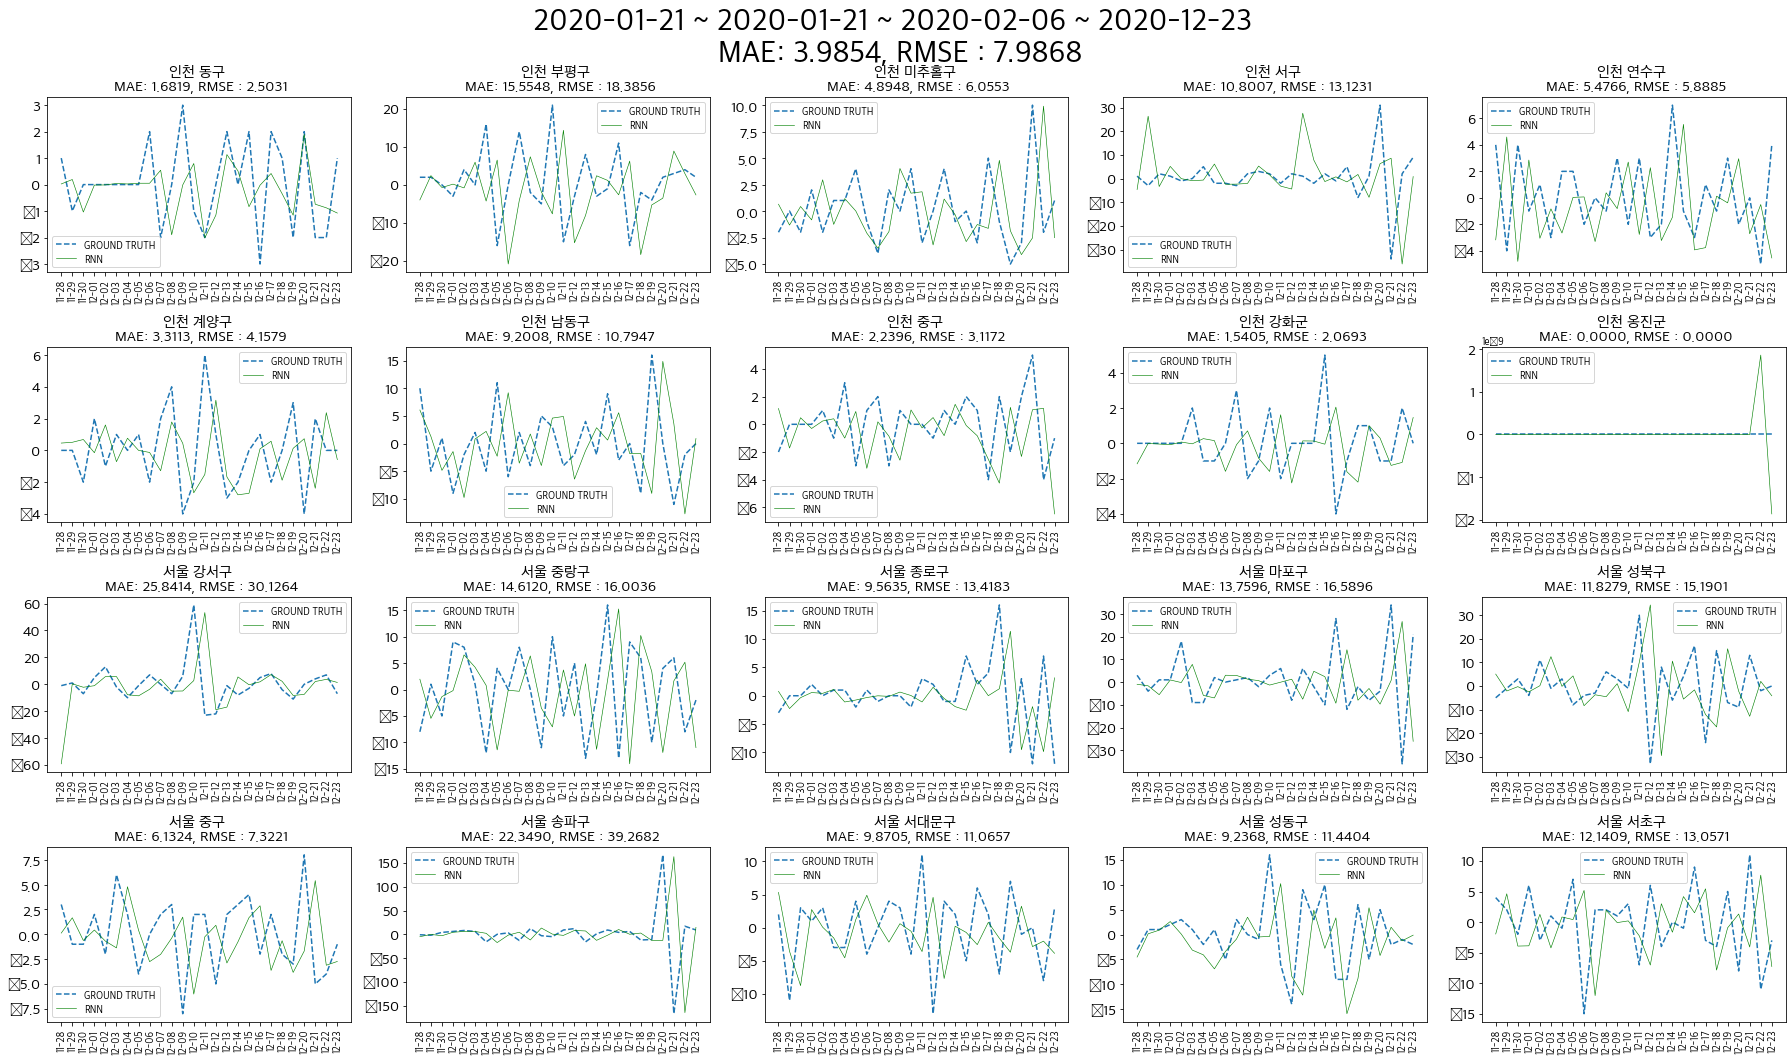

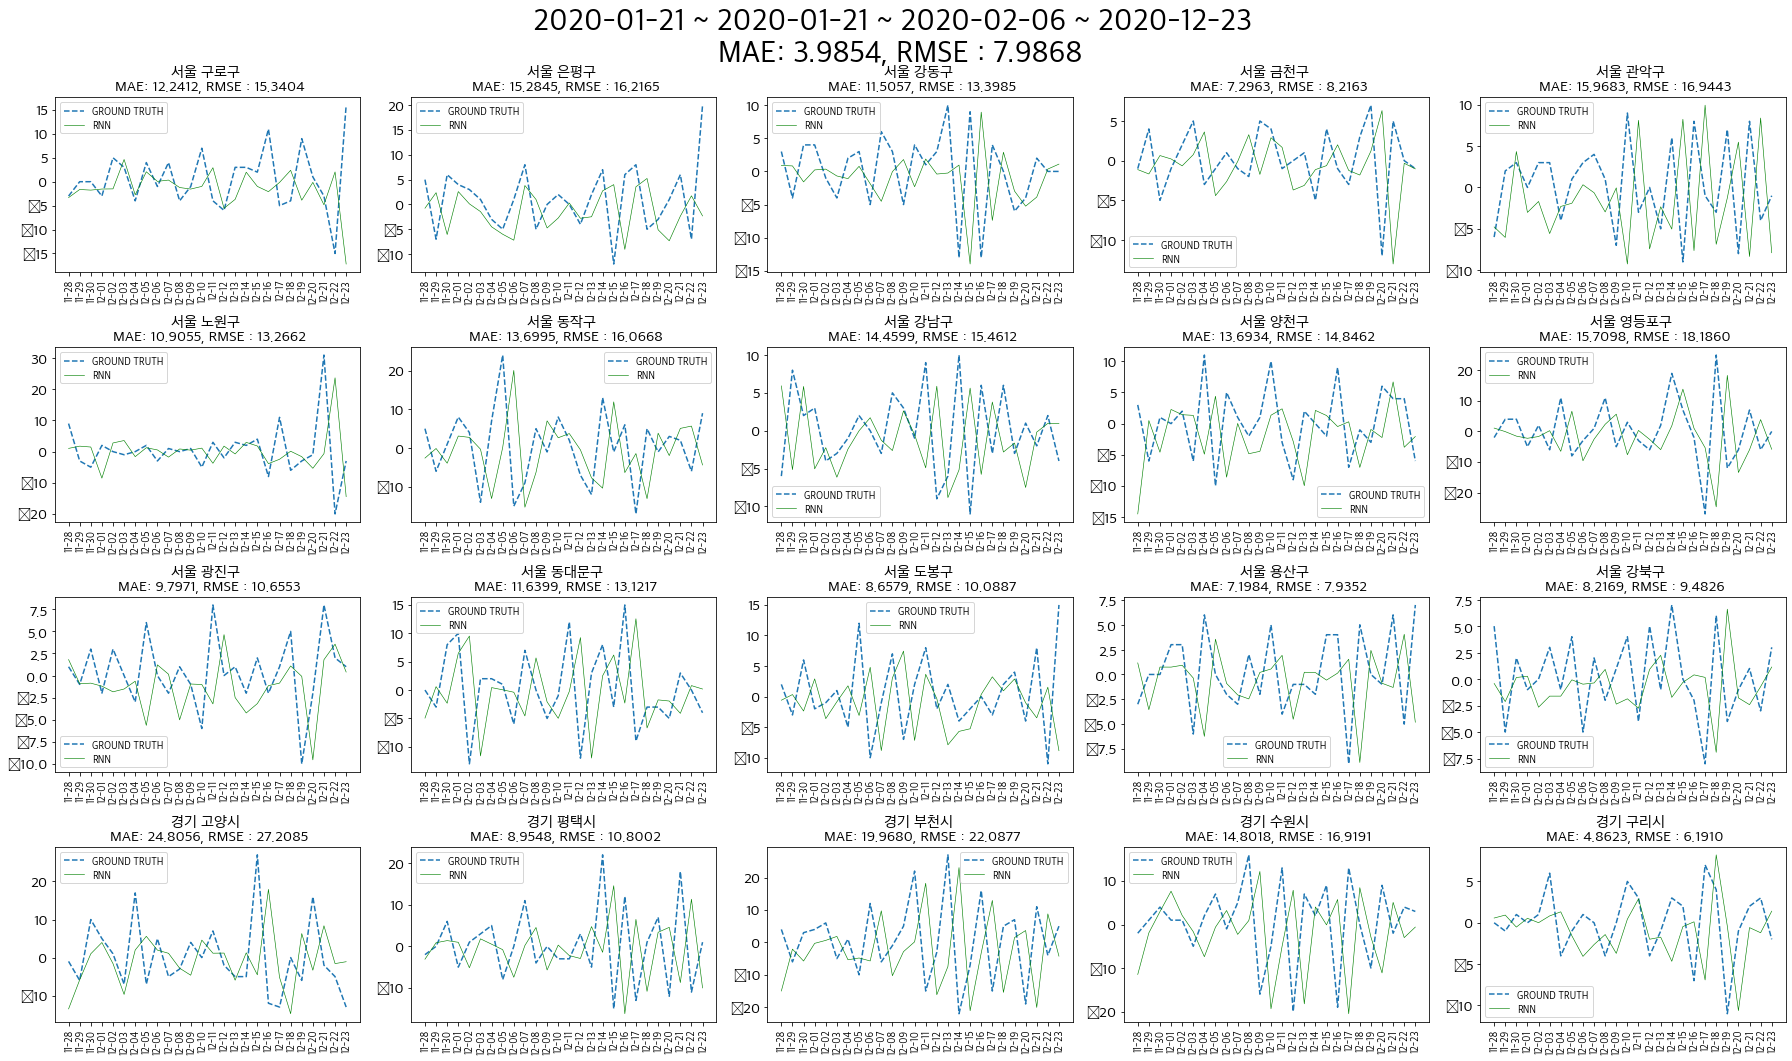

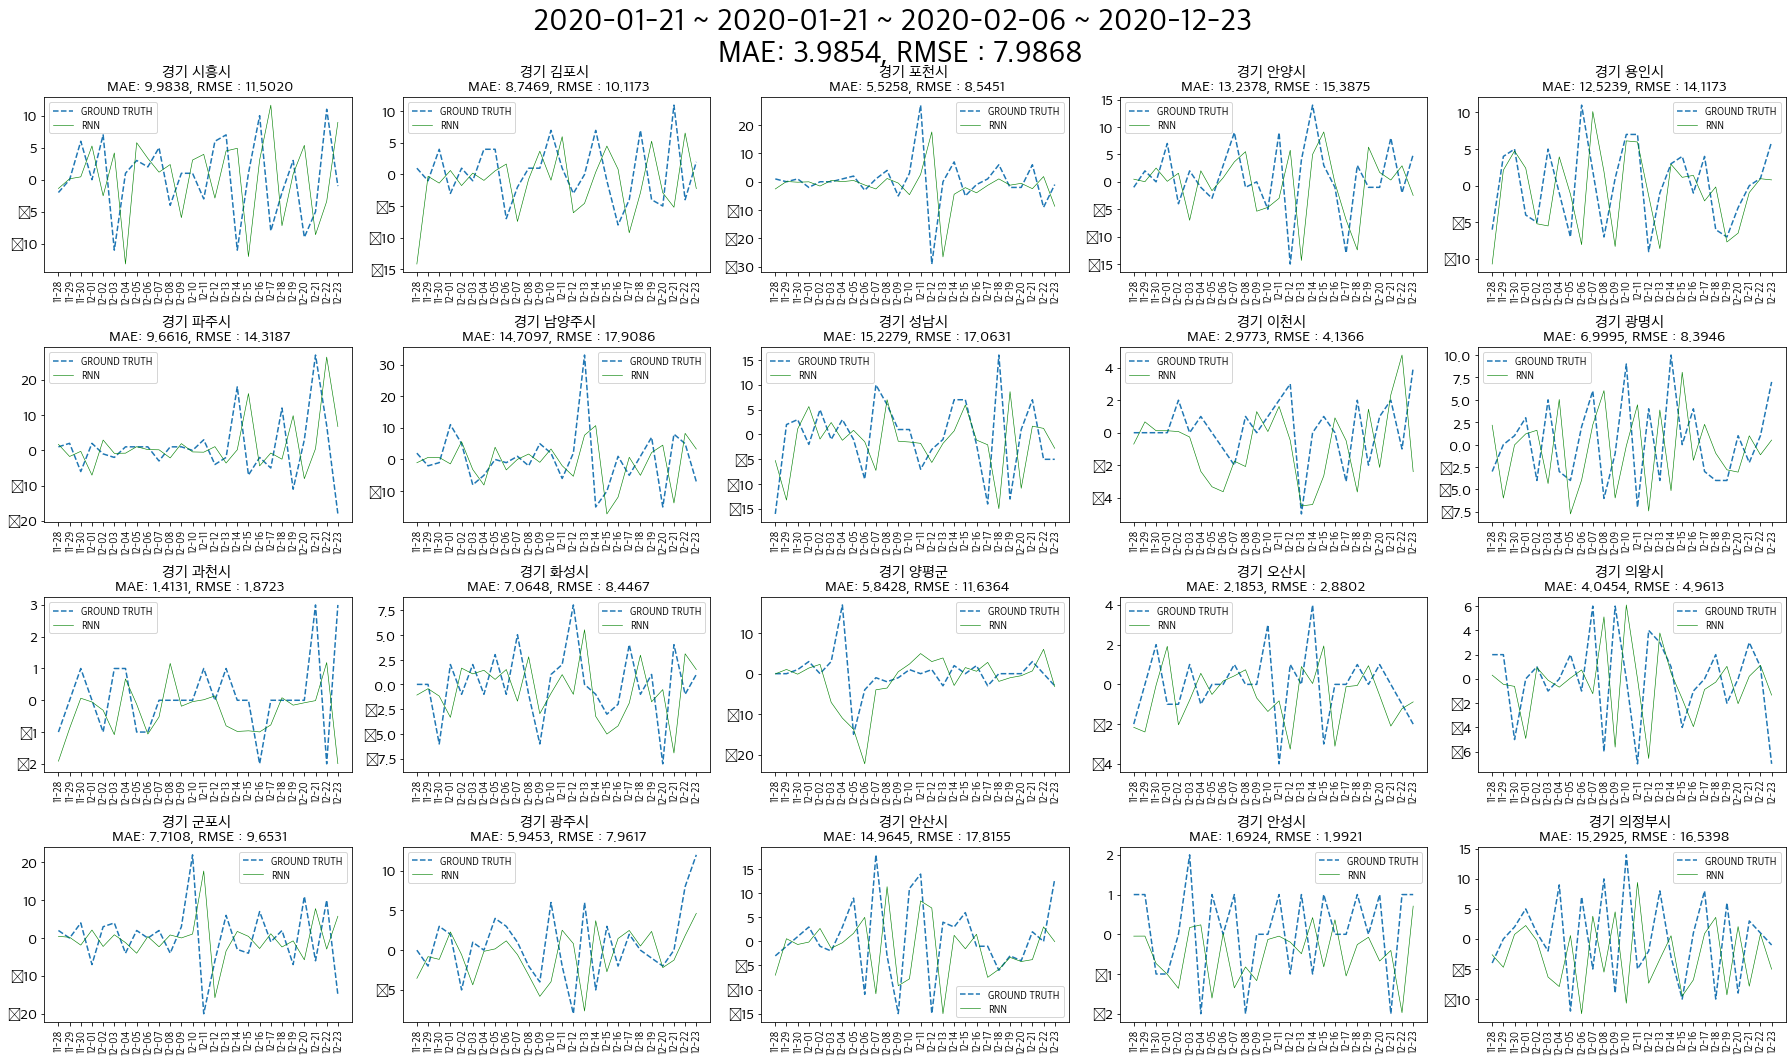

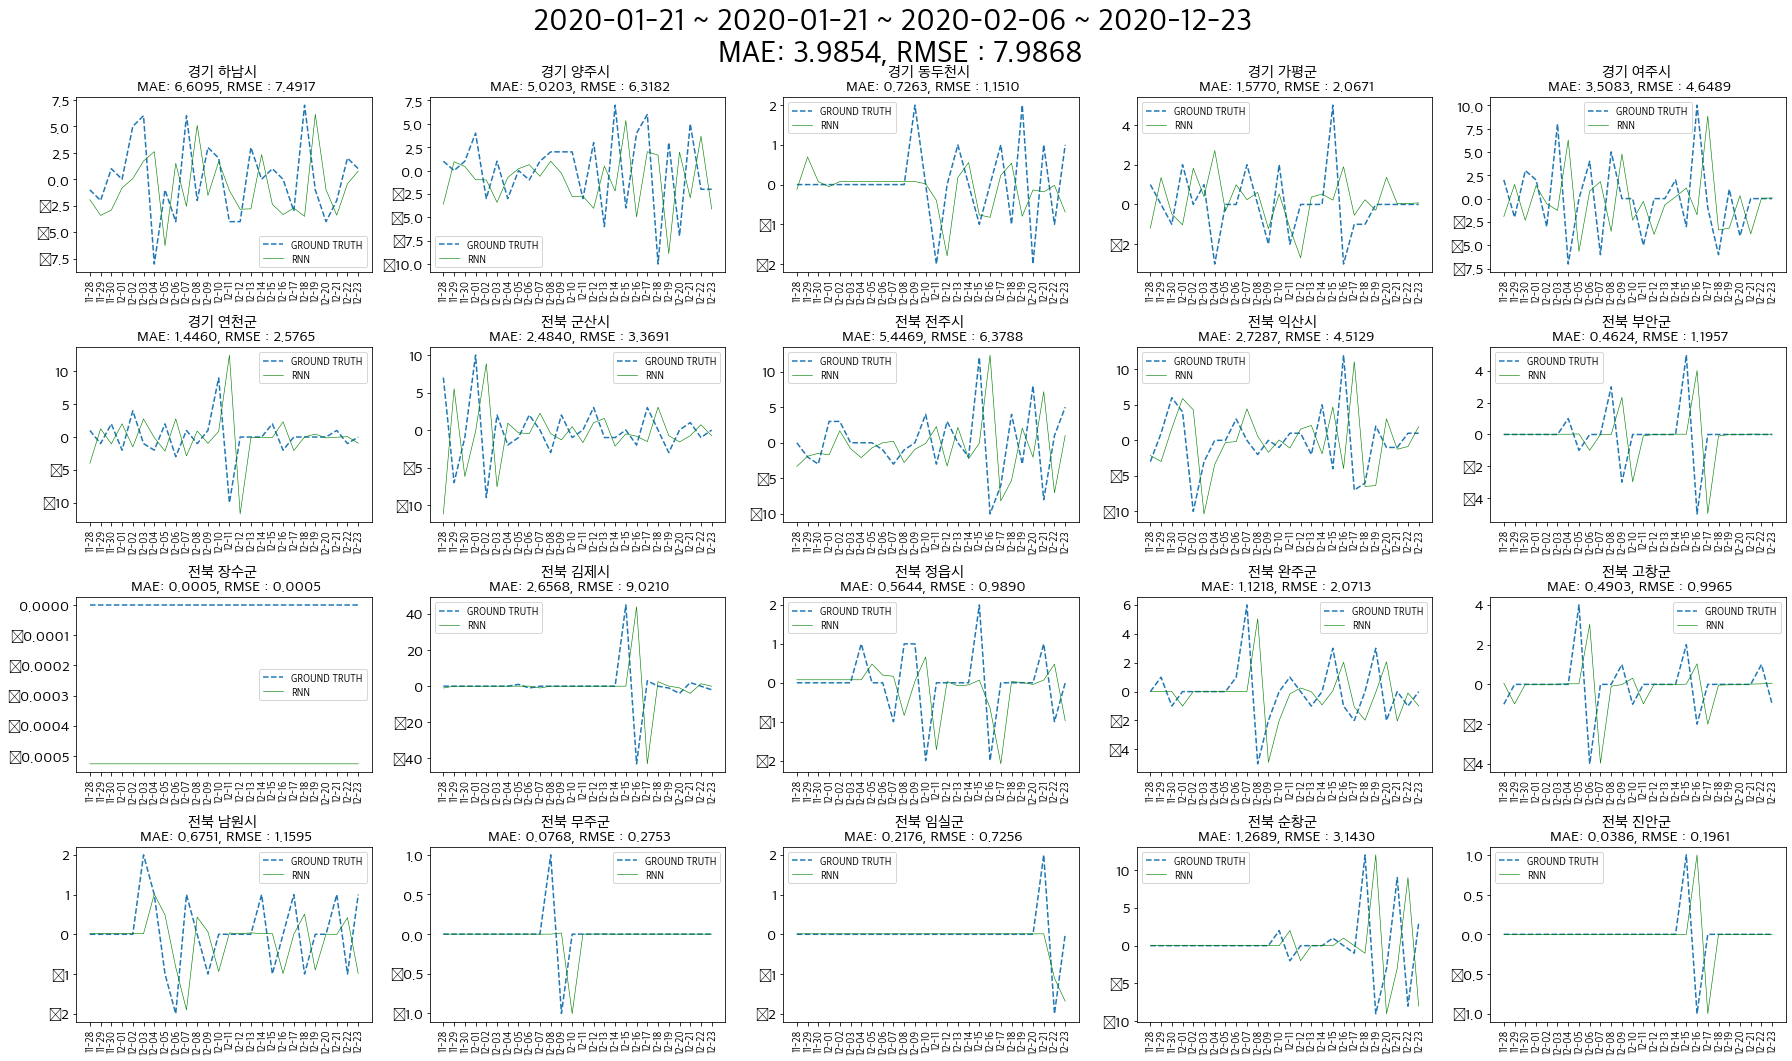

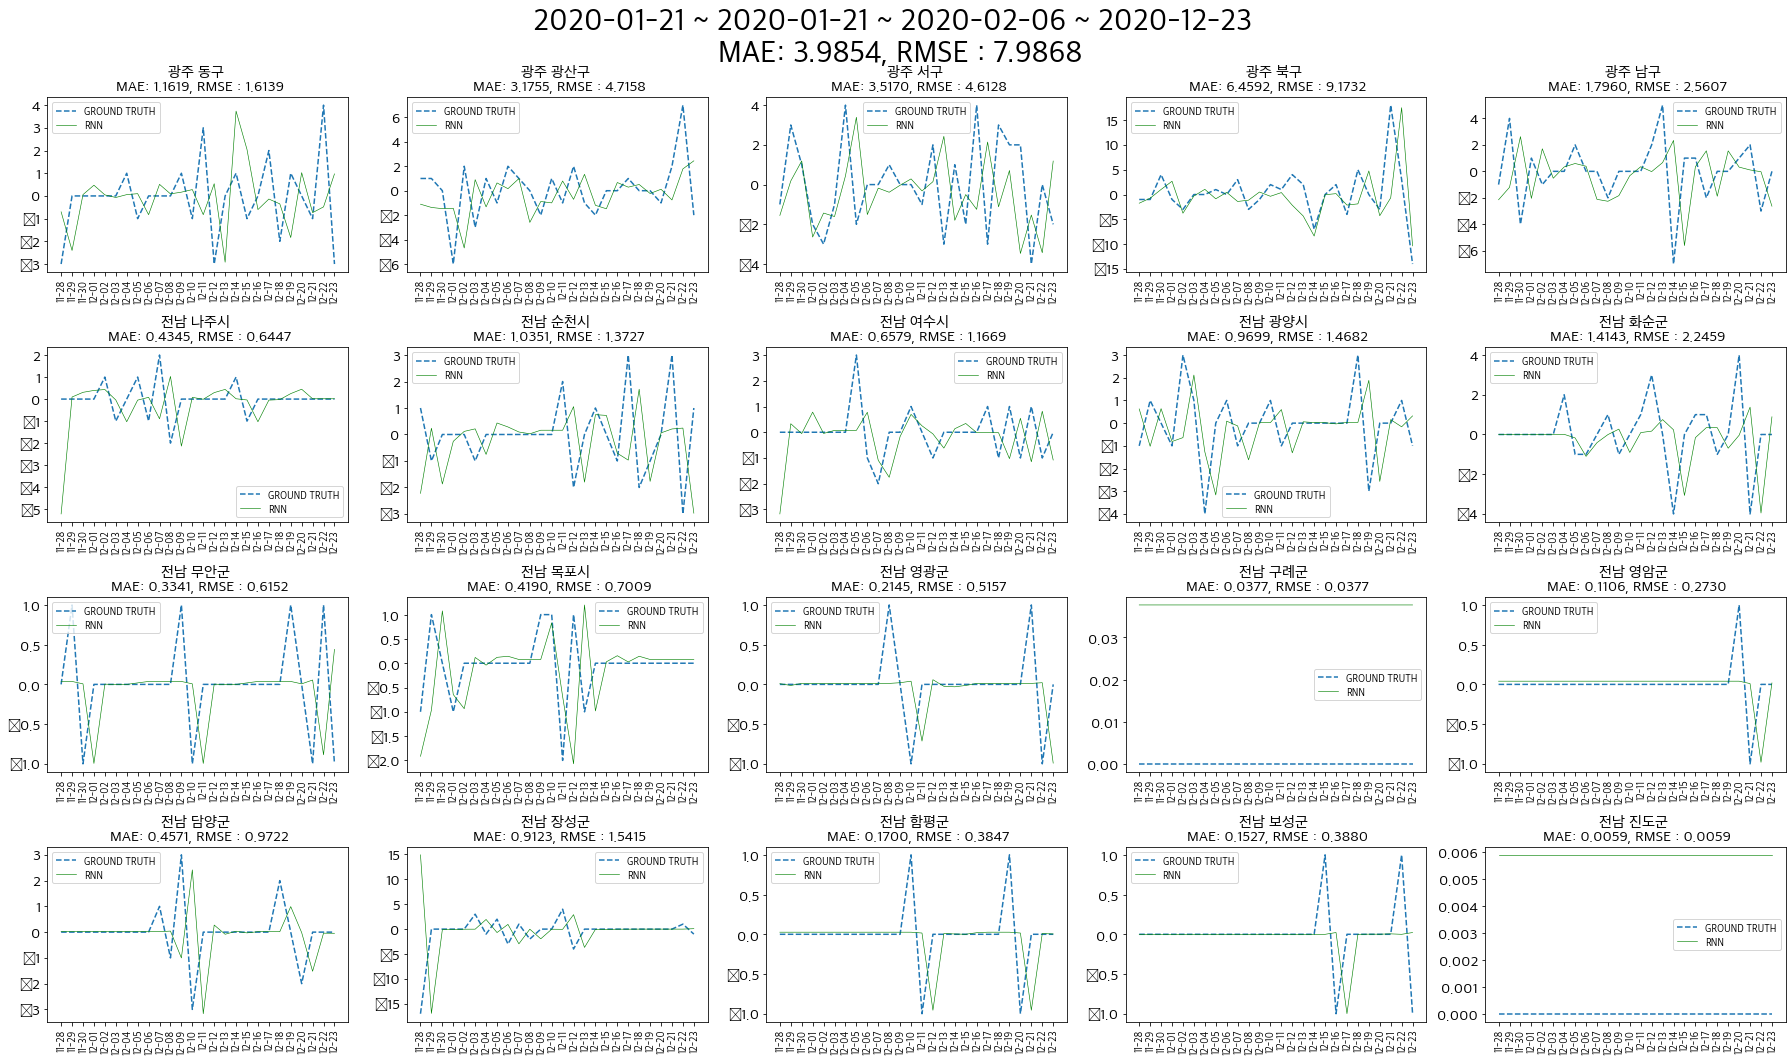

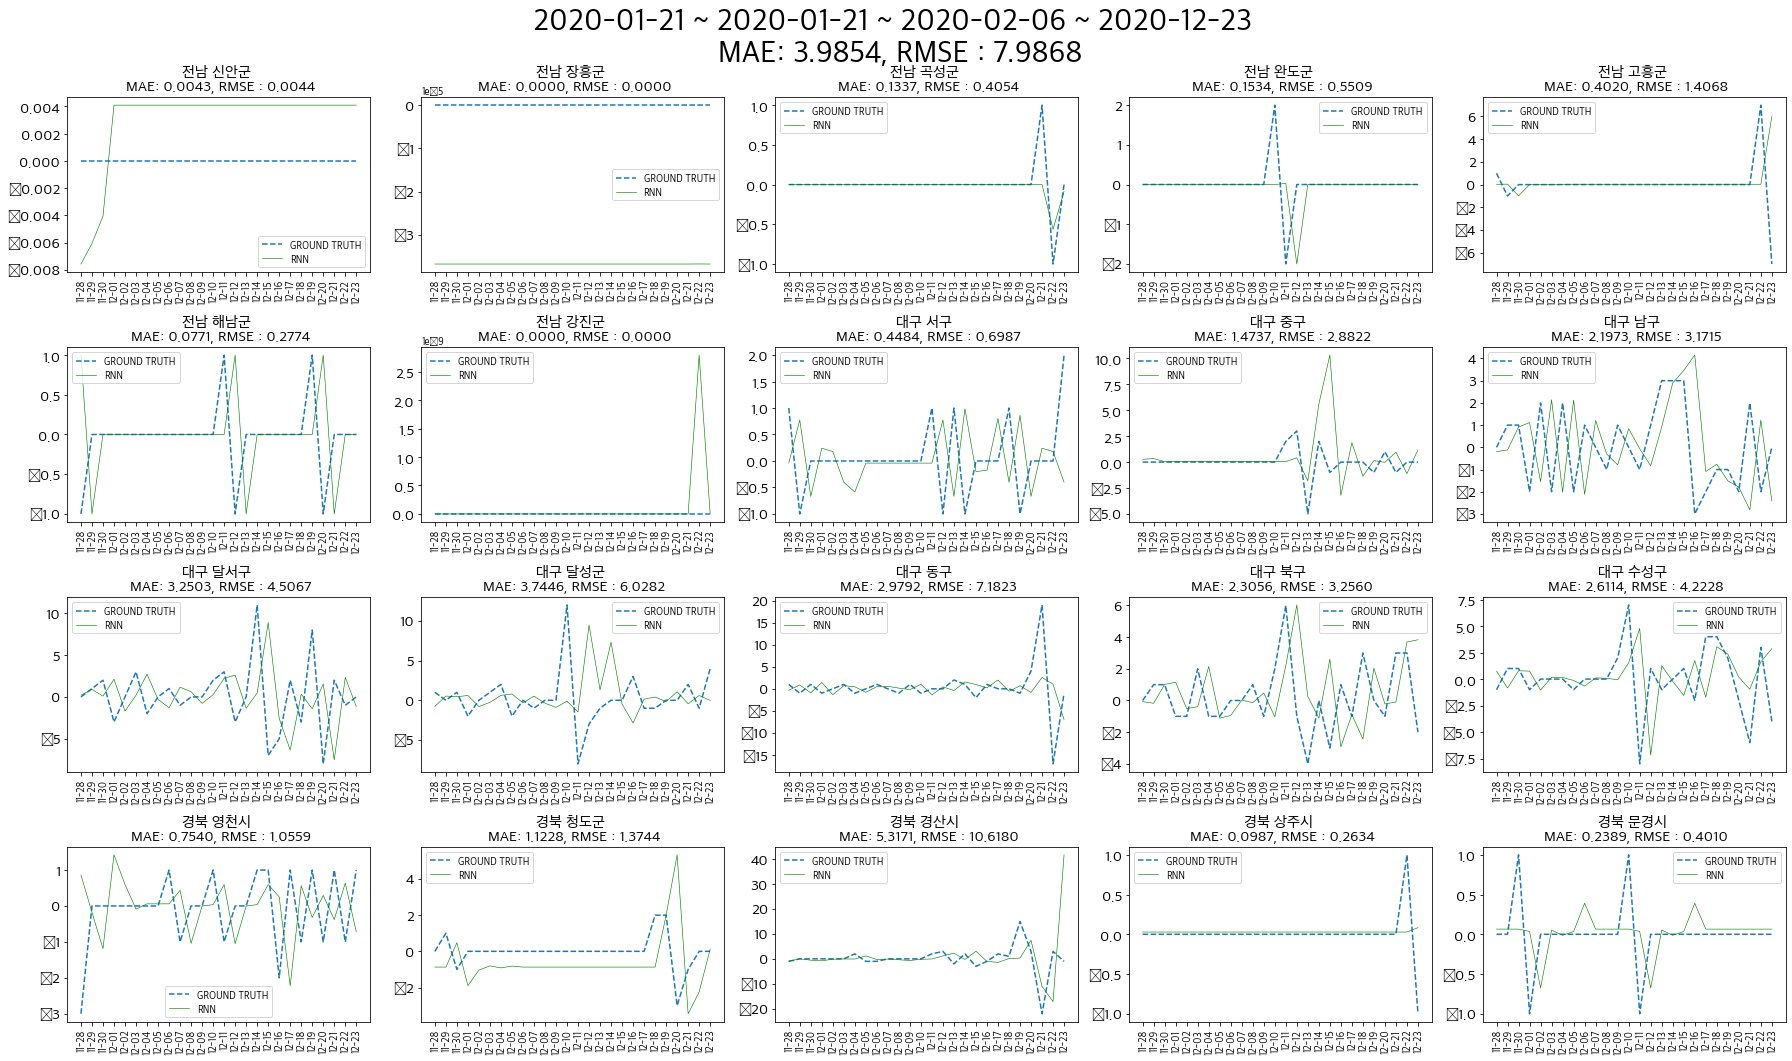

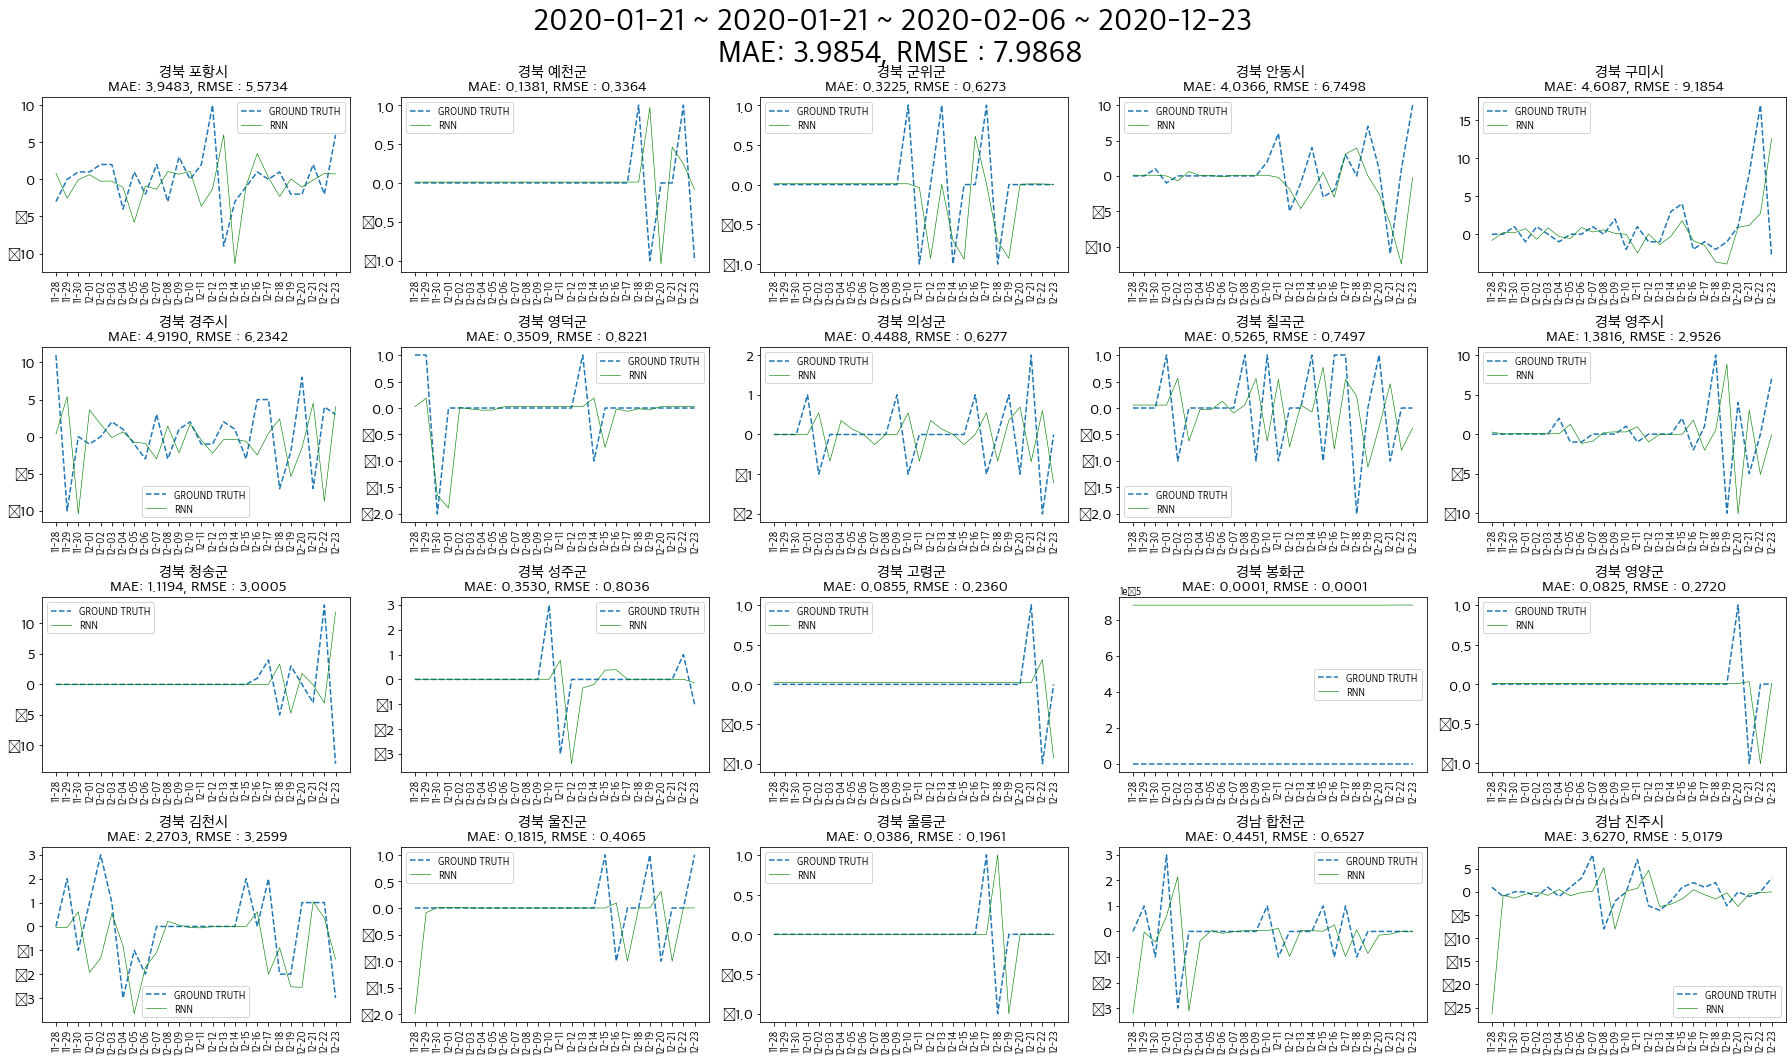

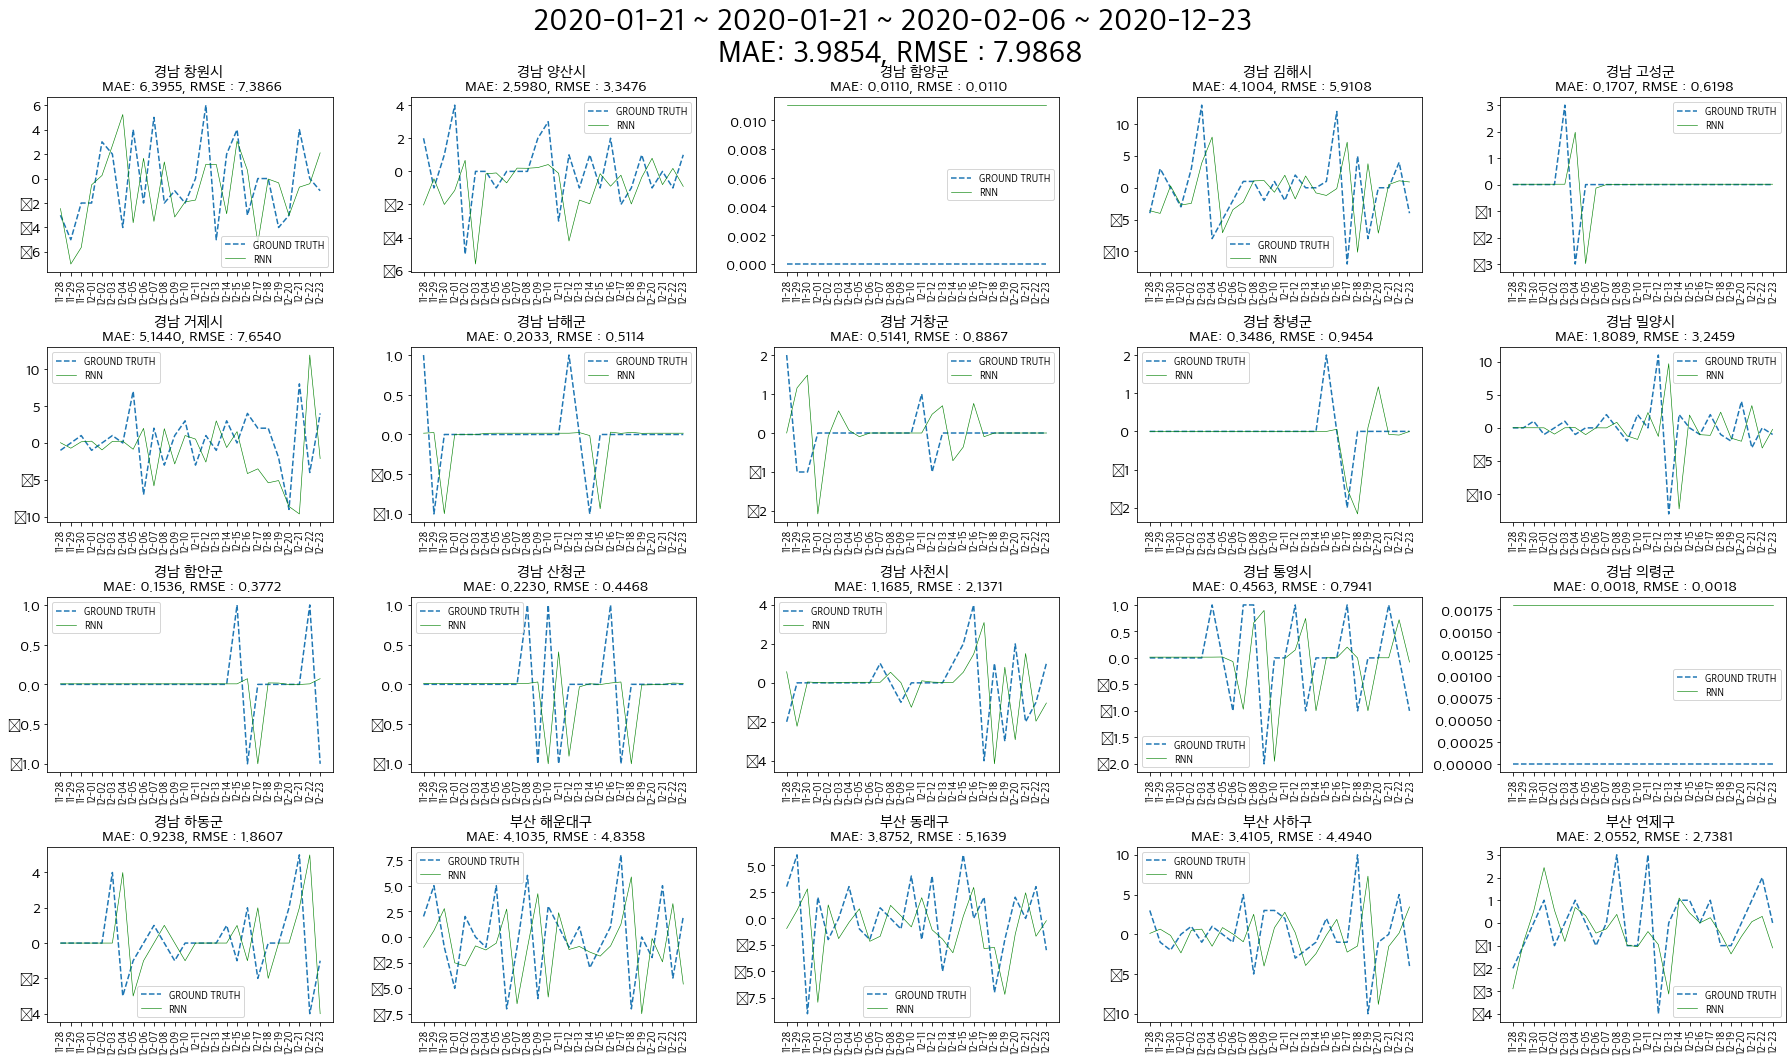

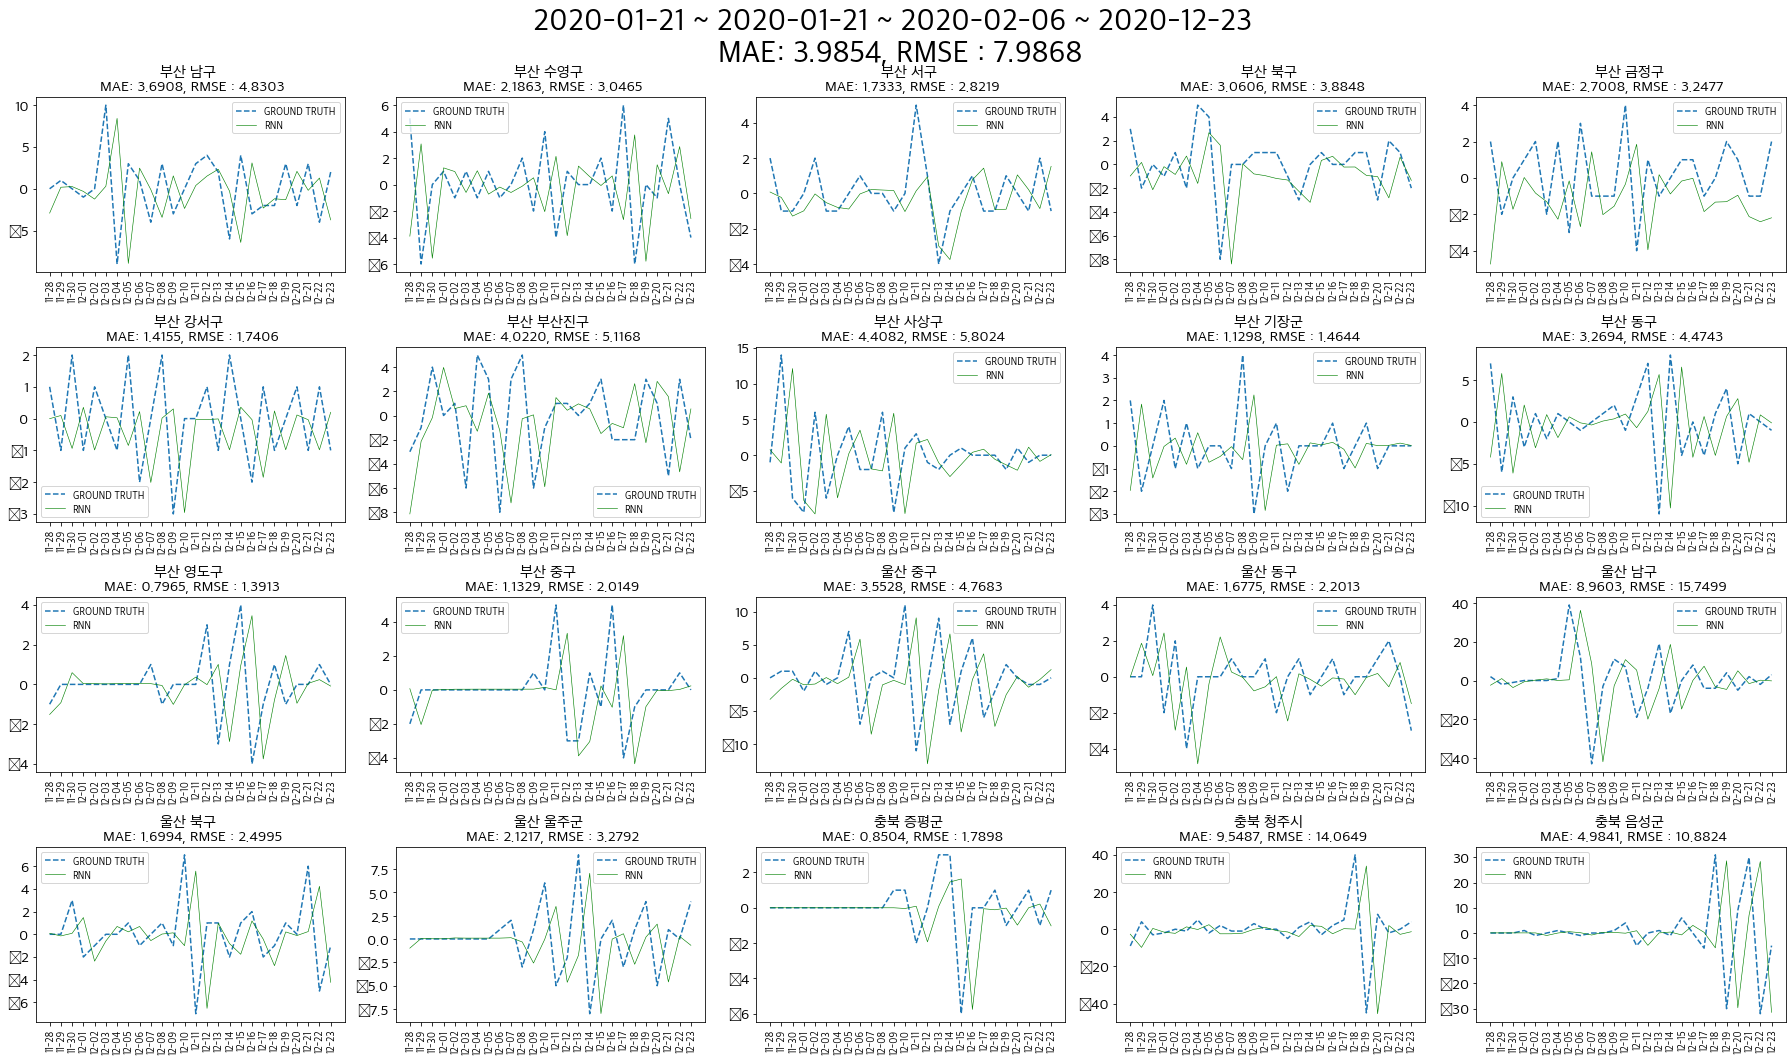

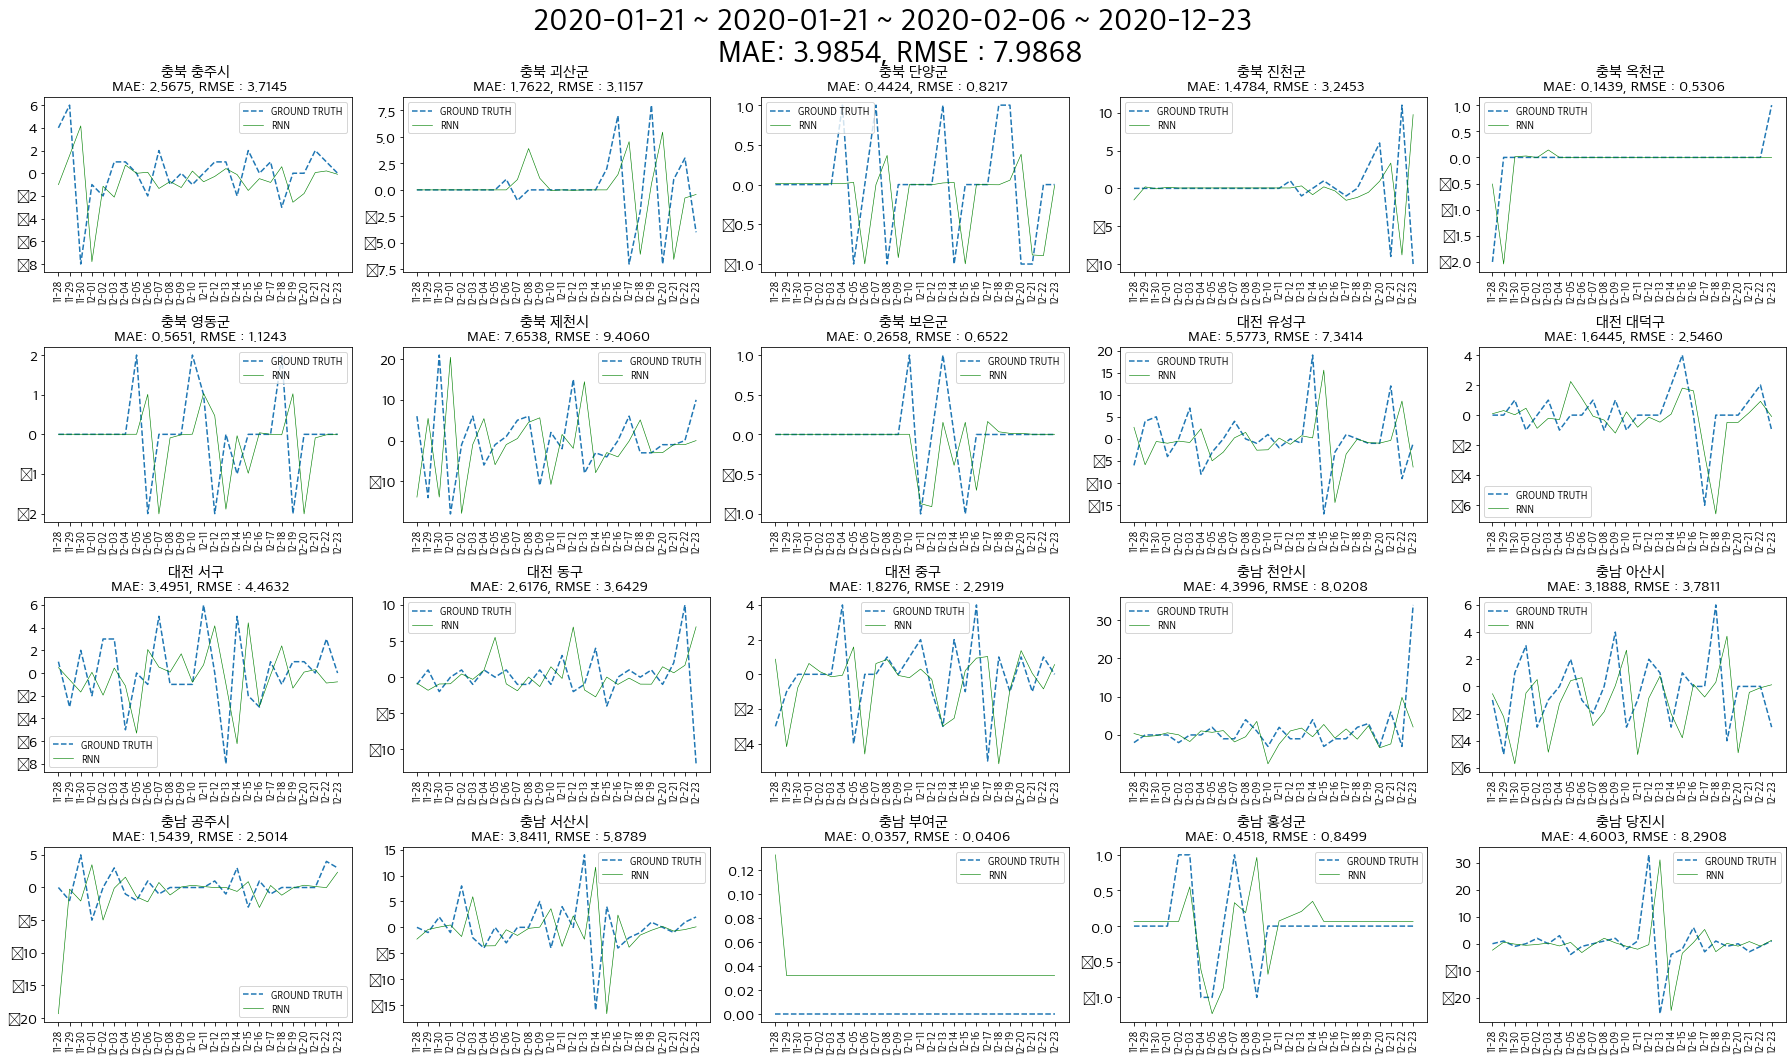

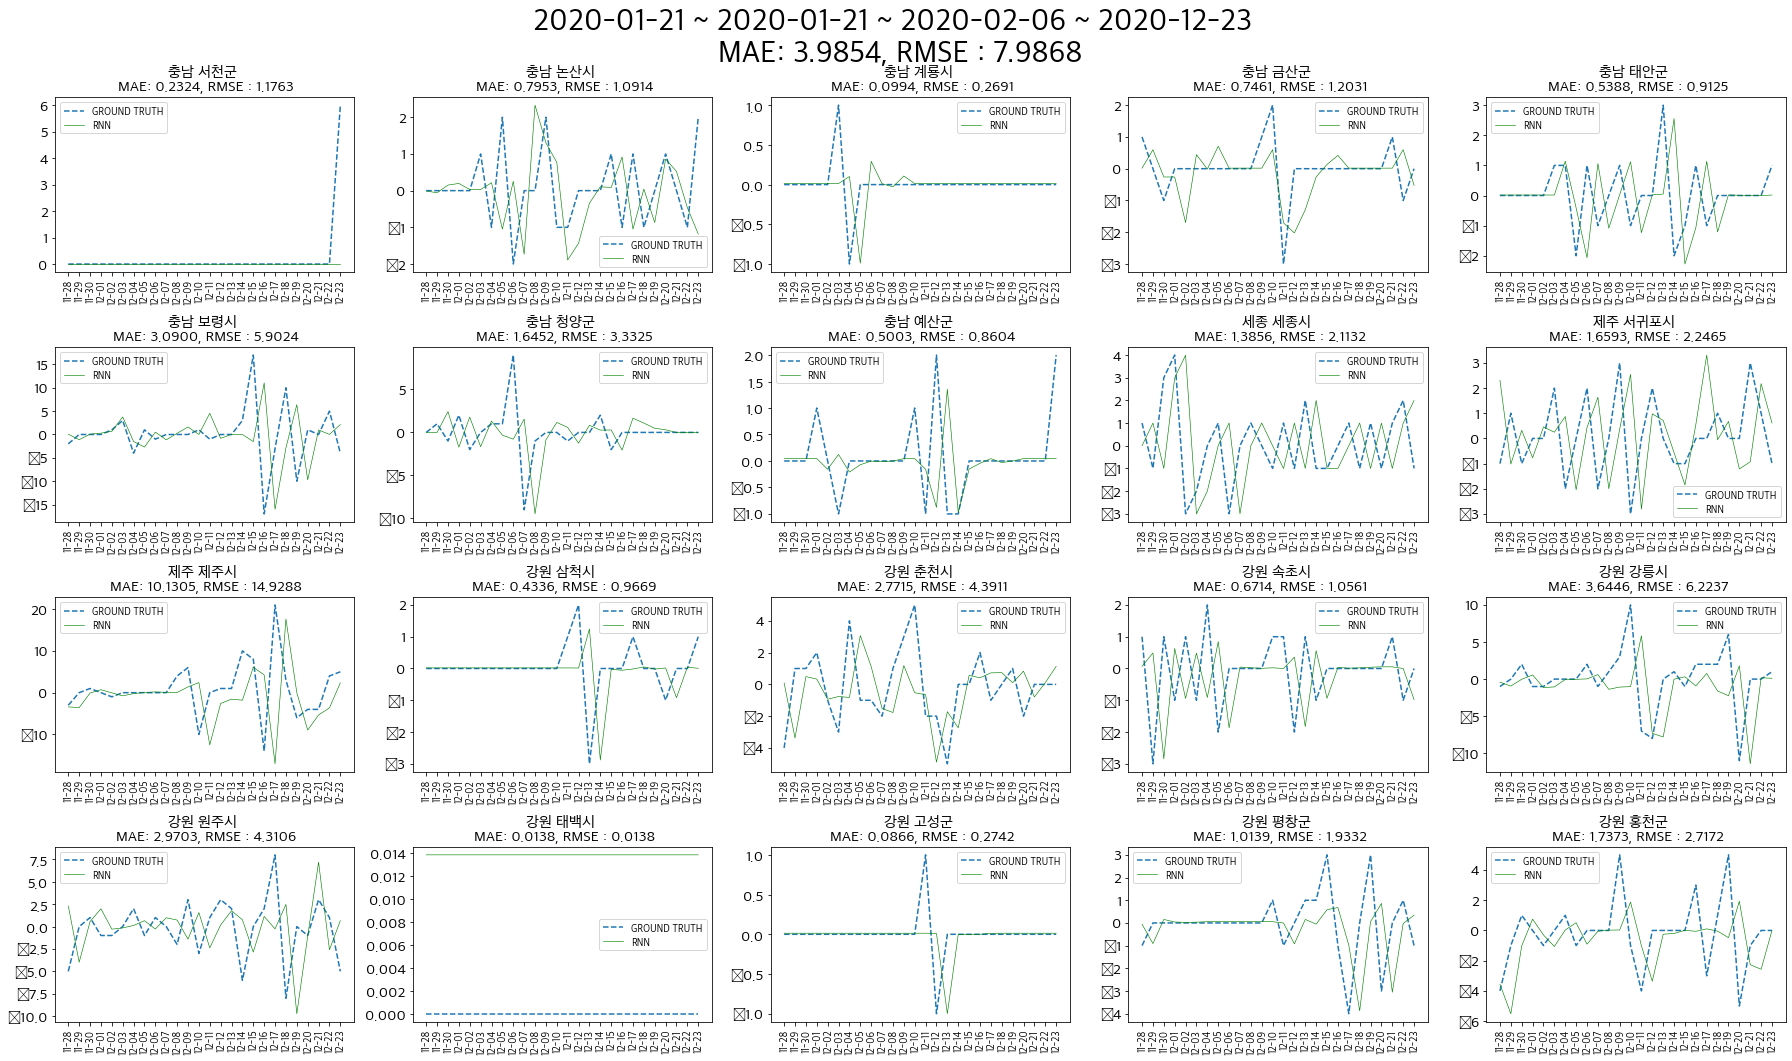

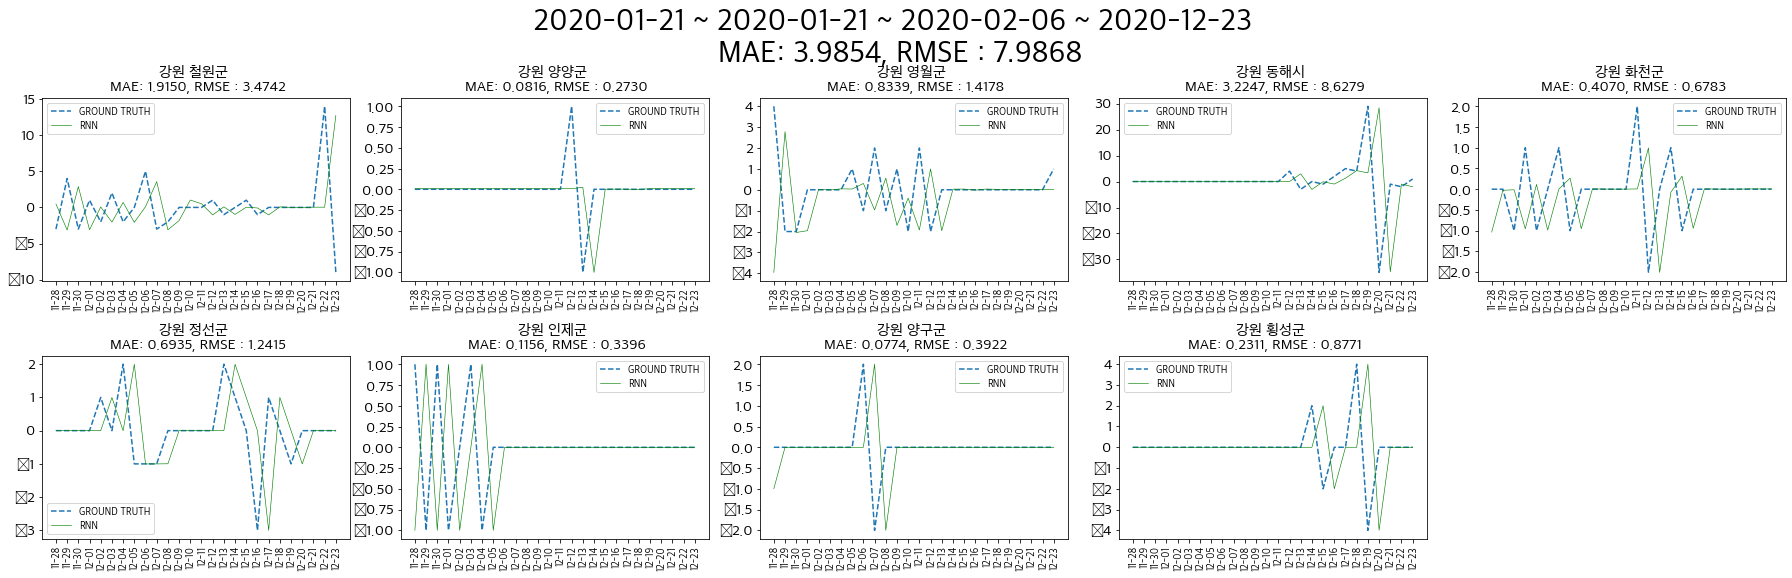

In [ ]:
from lib import save_figure_predict

GROUND_TRUTH = df.diff().iloc[-horizon:,]# + df.iloc[-(horizon+1):-1,].values
PRED = y_pred# + df.iloc[-(horizon+1):-1,].values

suptitle = f"{MODEL_NAME}"
save_figure_predict(
                    # df = df,
                    df = GROUND_TRUTH,
                    y_pred = PRED,
                    test_data = None,
                    region_dict = region_dict,
                    suptitle = suptitle,
                    legend = ['GROUND TRUTH', MODEL_NAME, 'Test_data'],
                    date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0])+TIME_STEPS + len(val[0])+TIME_STEPS*2]} ~ {df.index[-1]}",
                    MAE = MAE_LSTM_list, RMSE = RMSE_LSTM_list,
                    MAE_total = MAE_total, RMSE_total = RMSE_total, 
                    PATH=Figure_path
                    )

GROUND_TRUTH = df.diff().iloc[-horizon:,] + df.iloc[-(horizon+1):-1,].values
PRED = y_pred + df.iloc[-(horizon+1):-1,].values
suptitle = f"{MODEL_NAME}_{diff_}"
save_figure_predict(
                    # df = df,
                    df = GROUND_TRUTH,
                    y_pred = PRED,
                    test_data = None,
                    region_dict = region_dict,
                    suptitle = suptitle,
                    legend = ['GROUND TRUTH', MODEL_NAME, 'Test_data'],
                    date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0])+TIME_STEPS + len(val[0])+TIME_STEPS*2]} ~ {df.index[-1]}",
                    MAE = MAE_LSTM_list, RMSE = RMSE_LSTM_list,
                    MAE_total = MAE_total, RMSE_total = RMSE_total, 
                    PATH=Figure_path
                    )